In [119]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

from HJK.dynamics.systems import simple2Dsystem
from HJK.basis import monomials

import cvxpy as cp

## Define the system dynamics

In [120]:
io_simple2D = ct.NonlinearIOSystem(
    simple2Dsystem, None, inputs=('u'), outputs=('x1', 'x2'),
    states=('x1', 'x2'), name='simple2D')

### Plot free response of the system

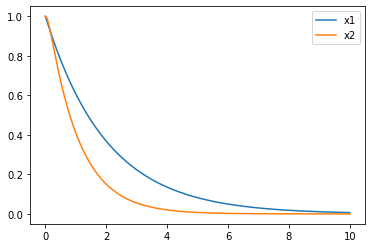

In [121]:
X0 = [1, 1]            
T = np.linspace(0, 10, 1000)   # Simulation 70 years of time
# Simulate the system
u = 0
params = {"mu":-0.5, "lam":-10.0}
t, y = ct.input_output_response(io_simple2D, T, u, X0, params)

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['x1', 'x2'])
plt.show(block=False)

### Linearize the system

In [122]:
eqpt = ct.find_eqpt(io_simple2D, X0, 0)
xeq = eqpt[0]                         # choose the nonzero equilibrium point
lin_simple2D = ct.linearize(io_simple2D, xeq, 0)
A = lin_simple2D.A
B = lin_simple2D.B

In [123]:
A=np.array([[-0.5, 0],[0,-10]])
A

array([[ -0.5,   0. ],
       [  0. , -10. ]])

## Collect random datapoints from a domain

In [124]:
domain = 5
dim = 2
numIC = 1000
np.random.seed(1)
X = np.random.uniform(low=-domain, high=domain, size=(dim,numIC)).astype(float) 
# X = np.array([[-1, -0.9, -0.9],[-1, 0.8, 1]])

## Generate basis functions
Monomials from d3s github

In [125]:
degree = 2
d3s_monomials = monomials.monomials(degree)
d3s_monomials.display(np.array([1.0, 1.0, 1.0, 1.0, 1, 1]),2)

1.000001 + 1.00000 x_1 + 1.00000 x_2 + 1.00000 x_1^2 + 1.00000 x_1 x_2 + 1.00000 x_2^2


In [126]:
Psi = d3s_monomials(X)
DPsi = d3s_monomials.diff(X)

# remove 1 and linear parts
Psi = Psi[dim+1:,:]
DPsi = DPsi[dim+1:,:]

## Setup Optimization problem

In [127]:
# get xdot values
t = 0
u = 0
F_z = simple2Dsystem(0,X,0,params)

# build gradient matrix grad_Psi * f(x)
Df_z = []
for i in range(numIC):
    Df_z.append(DPsi[:,:,i] @ F_z[:,i])
Df_z = np.array(Df_z).T

# get linear part
E = A
Ez = E @ X

# get observables and size
G_z = Psi
# get length of Psi to determine coefficient U dimensions
Nbs = np.shape(G_z)[0]

In [128]:
U = cp.Variable(shape=(dim, Nbs))
objective = cp.Minimize((cp.norm(U @ Df_z + F_z - A @ U @ G_z - Ez, 'fro')))
constraints  = []
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve(solver='SCS', verbose=True)
# The optimal value for x is stored in `x.value`.
# print(U.value)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) May 22 06:52:00 PM: Your problem has 6 variables, 0 constraints, and 0 parameters.
(CVXPY) May 22 06:52:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 22 06:52:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 22 06:52:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 22 06:52:00 PM: Compiling problem (target solver=SCS).
(CVXPY) May 22 06:52:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> S

In [129]:
U.value

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.11111111e+00, -6.41893060e-18, -2.91012471e-18]])